In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Import the AutoModelWithLMHead class
from transformers import AutoModelWithLMHead


In [ ]:
model = AutoModelWithLMHead.from_pretrained('gpt2')
!pip install sacremoses


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1712: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
import pandas as pd

path="/content/drive/MyDrive/Colab Notebooks/Training_Essay_Data.csv"
data=pd.read_csv(path)
data.to_csv('data.csv', index=False)
data.head()

# print(data.shape)
# print(data.head)
# data['text_len'] = data['text'].apply(len)

#     # Find the maximum essay length
# max_length = data['text_len'].max()
# print(data['text_len'])
# print(max_length)





,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


In [ ]:


# Separate the dataset into two based on the "generated" column value
generated_data_new = data[data['generated'] == 1]
human_data_new = data[data['generated'] == 0]
# generated_data_new=generated_data.iloc[1:5,:]
human_data_new_train=human_data_new.sample(n=10000).reset_index(drop=True)
# human_data_new_test=human_data_new.iloc[502:513,:]
human_data_new_test = human_data_new.iloc[1000:1010, :].reset_index(drop=True)


# generated_data_new=generated_data_new.iloc[1:51,:]
# human_data_new=human_data_new.iloc[1:51,:]





# Example of how to save these datasets to separate files
generated_data_new.to_csv('generated_data.csv', index=False)
human_data_new.to_csv('human_data.csv', index=False)
# print(generated_data_new.shape)
print(human_data_new_train.shape)
# print(generated_data_new.head())
print(human_data_new_train.head())


(10000, 2)
                                                text  generated
0  The article "Making Mona Lisa Smile," by Nich ...          0
1  I think this is benefiting being able to stay ...          0
2  I belive that the use of this technology to re...          0
3  Ok, so people think that the aliens made the f...          0
4  I think that school should not follow the busi...          0


In [ ]:
generated_data_new.shape

(11637, 2)

In [ ]:
human_data_new.shape

(17508, 2)

In [ ]:
data_new=data.sample(n=18000)
data_new.to_csv('data_new.csv',index=False)

In [ ]:
import torch
from torch.nn.functional import softmax, log_softmax
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'gpt2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the batch size
batch_size = 2  # You can adjust this based on your available memory

# Function to process a batch of texts
def process_batch(texts, model, tokenizer):
    if tokenizer.pad_token is None:
       tokenizer.pad_token = tokenizer.eos_token



    # Tokenize the texts and convert to tensors
    input_ids_list = [tokenizer.encode(text, return_tensors="pt")[0] for text in texts]
    text_lengths = [len(input_ids) for input_ids in input_ids_list]
    #  # Ensure all sequences are within the maximum length
    max_length = 1024
    input_ids_list = [input_ids[:max_length] for input_ids in input_ids_list]
    # Pad the sequences to the maximum length in the batch
    input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids_list, batch_first=True, padding_value=tokenizer.pad_token_id)

    # Move input to device
    input_ids_padded = input_ids_padded.to(device)
    text_lengths = torch.tensor(text_lengths, dtype=torch.float).to(device)
     # Ensure no gradients are calculated to save memory and then find logits
         # Set logits for EOS token to negative infinity

    with torch.no_grad():
      logits = model(input_ids_padded).logits
      # Set logits for EOS token to negative infinity
    # eos_token_id = tokenizer.eos_token_id
    # logits[:, :, eos_token_id] = float('-inf')













    # Get the probabilities from the logits using softmax
    probs = softmax(logits, dim=-1)
    # Get the log probabilities from the probabilities using log_softmax
    log_probs = log_softmax(logits, dim=-1)
    # Multiply the probabilities and the log probabilities element-wise
    p_log_p = probs * log_probs
    # Sum up the p_log_p values along the last dimension
    p_log_p_sum = torch.sum(p_log_p, dim=-1)
    # Negate the p_log_p_sum values to get entropy
    entropy = -p_log_p_sum
    return entropy


# Create batches of texts
generated_text_batches = [generated_data_new['text'][i:i+batch_size] for i in range(0, len(generated_data_new), batch_size)]
human_text_batches = [human_data_new['text'][i:i+batch_size] for i in range(0, len(human_data_new), batch_size)]


# Function to calculate statistical features of entropy values
def calculate_statistics(entropy_values):
    mean_entropy = torch.mean(entropy_values)
    median_entropy = torch.median(entropy_values)
    variance_entropy = torch.var(entropy_values)
    skewness_entropy = skew(entropy_values.cpu().numpy())
    kurtosis_entropy = kurtosis(entropy_values.cpu().numpy())
    return mean_entropy, median_entropy, variance_entropy, skewness_entropy, kurtosis_entropy

# Initialize lists to store features
generated_data_features = []
human_data_features = []

# Process each batch of generated texts
for batch in generated_text_batches:
    entropies = process_batch(batch, model, tokenizer)
    for entropy_values in entropies:
        # Calculate statistical features
        mean_entropy, median_entropy, variance_entropy, skewness_entropy, kurtosis_entropy = calculate_statistics(entropy_values)
        # Append features to list
        generated_data_features.append((mean_entropy, median_entropy, variance_entropy, skewness_entropy, kurtosis_entropy))

# Process each batch of human texts
for batch in human_text_batches:
    entropies = process_batch(batch, model, tokenizer)
    for entropy_values in entropies:
        # Calculate statistical features
        mean_entropy, median_entropy, variance_entropy, skewness_entropy, kurtosis_entropy = calculate_statistics(entropy_values)
        # Append features to list
        human_data_features.append((mean_entropy, median_entropy, variance_entropy, skewness_entropy, kurtosis_entropy))

# Convert lists to tensors if needed
generated_data_features = torch.tensor(generated_data_features)
human_data_features = torch.tensor(human_data_features)


print(generated_data_features)
print(human_data_features)








Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Token indices sequence length is longer than the specified maximum sequence length for this model (1081 > 1024). Running this sequence through the model will result in indexing errors


tensor([[ 3.1105,  3.2684,  3.3378, -0.0672, -1.0568],
        [ 3.1179,  3.1510,  3.5201,  0.0315, -0.9534],
        [ 3.1776,  3.3550,  3.2142, -0.0742, -0.9278],
        [ 3.1660,  3.2980,  3.3267,  0.0553, -0.8165],
        [ 3.1416,  3.3252,  3.3431,  0.0202, -0.8599],
        [ 3.0913,  3.0967,  3.2673,  0.0165, -0.9636],
        [ 3.0752,  3.1438,  3.2477,  0.0123, -0.9818],
        [ 3.2950,  3.2955,  3.5045,  0.0731, -0.8949],
        [ 3.2257,  3.3690,  3.3135, -0.0360, -0.9177],
        [ 3.2157,  3.3301,  3.5335,  0.0219, -0.9292],
        [ 3.0687,  3.1260,  3.2356,  0.0599, -0.8623],
        [ 3.1750,  3.2904,  3.3826,  0.0422, -0.8977],
        [ 3.1103,  3.2519,  3.2724,  0.0188, -0.9131],
        [ 3.1125,  3.2526,  3.3226,  0.0427, -0.8649],
        [ 3.1055,  3.2258,  3.2577,  0.0490, -0.8602],
        [ 3.6345,  3.8238,  4.0700, -0.1467, -1.0390],
        [ 3.0728,  3.2079,  3.1054, -0.0452, -0.9146],
        [ 3.0752,  3.2140,  3.1633, -0.0395, -0.8538],
        [ 

In [ ]:

column_names = ['normalized_entropy', 'median_entropy', 'variance_entropy', 'skewness_entropy', 'kurtosis_entropy']

# Create DataFrames for generated data and human data
generated_data_df = pd.DataFrame(generated_data_features, columns=column_names)
human_data_df = pd.DataFrame(human_data_features, columns=column_names)
generated_data_df['generated']=1
human_data_df['generated']=0
df = pd.concat([generated_data_df, human_data_df], ignore_index=True)



# # Display the datasets
# print("Generated Data Features:")
# print(generated_data_df.head())
# print("\nHuman Data Features:")
# print(human_data_df.head())
print(df)


    normalized_entropy  median_entropy  variance_entropy  skewness_entropy  \
0             3.110498        3.268389          3.337810         -0.067226   
1             3.117894        3.151026          3.520068          0.031495   
2             3.177591        3.354952          3.214185         -0.074241   
3             3.165998        3.298025          3.326699          0.055291   
4             3.141640        3.325203          3.343081          0.020164   
..                 ...             ...               ...               ...   
95            3.733082        3.969444          2.987314         -0.373913   
96            4.995233        5.987725          3.520384         -1.230214   
97            3.371163        3.546493          2.832702         -0.248486   
98            5.100606        5.999963          2.661467         -1.163007   
99            4.194368        4.330966          2.193647         -0.596581   

    kurtosis_entropy  generated  
0          -1.056789         

In [ ]:
df.iloc[51:100,:]

,normalized_entropy,median_entropy,variance_entropy,skewness_entropy,kurtosis_entropy,generated
51,3.781375,4.027416,2.821344,-0.342219,-0.497629,0
52,4.272886,4.302235,3.420157,-0.298982,-0.747111,0
53,4.385856,4.534761,2.636780,-0.400072,-0.160771,0
54,3.747545,3.899719,1.898608,-0.468827,0.391431,0
55,4.223971,4.260043,3.290447,-0.395210,-0.729641,0
56,3.987216,4.198242,3.314527,-0.442284,-0.380335,0
57,3.738080,3.934405,2.418682,-0.457380,-0.023292,0
58,3.407250,3.466985,1.882355,-0.279437,0.157961,0
59,4.427620,4.745440,3.584950,-0.600620,-0.684947,0
60,3.488767,3.746465,3.097589,-0.236264,-0.810461,0


In [ ]:
df.iloc[1:51,:]

,normalized_entropy,median_entropy,variance_entropy,skewness_entropy,kurtosis_entropy,generated
1,3.117894,3.151026,3.520068,0.031495,-0.953421,1
2,3.177591,3.354952,3.214185,-0.074241,-0.927820,1
3,3.165998,3.298025,3.326699,0.055291,-0.816541,1
4,3.141640,3.325203,3.343081,0.020164,-0.859872,1
5,3.091264,3.096693,3.267325,0.016501,-0.963564,1
6,3.075166,3.143825,3.247669,0.012299,-0.981799,1
7,3.295042,3.295530,3.504471,0.073112,-0.894910,1
8,3.225663,3.368993,3.313457,-0.036034,-0.917680,1
9,3.215743,3.330147,3.533526,0.021925,-0.929169,1
10,3.068692,3.126040,3.235627,0.059876,-0.862288,1


In [ ]:
df_new=df.sample(n=100)

In [ ]:
df_new.head()

,normalized_entropy,median_entropy,variance_entropy,skewness_entropy,kurtosis_entropy,generated
72,3.124243,3.226076,2.369214,-0.188696,-0.180676,0
73,3.276037,3.343618,2.480300,-0.030964,-0.324220,0
32,3.075840,3.257627,3.289734,-0.048496,-0.972142,1
95,3.733082,3.969444,2.987314,-0.373913,-0.535519,0
39,3.058590,3.247075,3.217526,-0.043359,-0.955898,1


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Assuming df_new is already created and populated
X = df_new.iloc[:, 0:5].values  # Convert to NumPy array
y = df_new['generated'].values  # Convert to NumPy array

# # Standardize the features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instantiate the model, define the loss function and optimizer
model = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_classes = (predictions > 0.5).float()
    accuracy = accuracy_score(y_test_tensor, predicted_classes)
    print(f'Accuracy: {accuracy:.4f}')


Epoch [10/100], Loss: 0.6848
Epoch [20/100], Loss: 0.6819
Epoch [30/100], Loss: 0.6790
Epoch [40/100], Loss: 0.6760
Epoch [50/100], Loss: 0.6730
Epoch [60/100], Loss: 0.6698
Epoch [70/100], Loss: 0.6665
Epoch [80/100], Loss: 0.6628
Epoch [90/100], Loss: 0.6589
Epoch [100/100], Loss: 0.6545
Accuracy: 0.5333


In [ ]:
!pip install sacremoses


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 10.9 MB/s eta 0:00:00


In [ ]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'gpt2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Function to process each dataset
def process_dataset(dataset_name):
    # Load the dataset
    data = pd.read_csv(dataset_name)

    # Create empty lists for each category
    top10 = []
    top100 = []
    top1000 = []
    top1000plus=[]

    # Iterate through each text in the dataset
    for text in data['text']:
        # Tokenize the text
        tokenizer.pad_token = tokenizer.eos_token
        inputs = tokenizer(text, return_tensors="pt", truncation=True,padding=True)
        input_ids = inputs.input_ids.to(device)

        # Get the logits from the model
        logits = model(input_ids).logits

        # Iterate through each word in the sentence
        for word in text.split():
            # Find the index of the word in the vocabulary
            word_idx = tokenizer.encode(word)[0]
            # Get the logits for the word
            word_logits = logits[0, :, word_idx]
            # Sort the logits for the word in decreasing order and get the corresponding indices
            sorted_logits, sorted_indices = torch.sort(word_logits, descending=True)
            # Count the number of words with higher probabilities than the current word
            higher_prob_count = torch.sum(sorted_logits > word_logits).item()
            # Check if the word's probability is in the top 10, top 100, or top 1000
            if higher_prob_count <= 10:
                top10.append(word)
            elif 10 < higher_prob_count <= 100:
                top100.append(word)
            elif 100 < higher_prob_count <= 1000:
                top1000.append(word)
            elif higher_prob_count>1000:
                top1000plus.append(word)

    # Print the counts of words in each category
    print(f"Top 10 words count in {dataset_name}: {len(top10)}")
    print(f"Top 100 words count in {dataset_name}: {len(top100)}")
    print(f"Top 1000 words count in {dataset_name}: {len(top1000)}")
    print(f"above 1000 words count in {dataset_name}: {len(top1000plus)}")

# Process each dataset
process_dataset('generated_data.csv')
process_dataset('human_data.csv')


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


Top 10 words count in generated_data.csv: 24
Top 100 words count in generated_data.csv: 179600
Top 1000 words count in generated_data.csv: 3455540
above 1000 words count in generated_data.csv: 0
Top 10 words count in human_data.csv: 0
Top 100 words count in human_data.csv: 54799
Top 1000 words count in human_data.csv: 7476784
above 1000 words count in human_data.csv: 0


In [ ]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'gpt2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Function to process each dataset
def process_dataset(dataset_name):
    # Load the dataset
    data = pd.read_csv(dataset_name)

    # Create empty lists for each category
    top10 = []
    top100 = []
    top1000 = []
    top1000plus=[]

    # Iterate through each text in the dataset
    for text in data['text']:

       top10_count=0
       top100_count=0
       top1000_count=0
       top1000plus_count=0
        # Tokenize the text
       tokenizer.pad_token = tokenizer.eos_token
       inputs = tokenizer(text, return_tensors="pt", truncation=True,padding=True)
       input_ids = inputs.input_ids.to(device)

        # Get the logits from the model
       logits = model(input_ids).logits

        # Iterate through each word in the sentence
       for word in text.split():
        # Find the index of the word in the vocabulary
        word_idx = tokenizer.encode(word)[0]
        # Get the logits for the word
        word_logits = logits[0, :, word_idx]
        # Sort the logits for the word in decreasing order and get the corresponding indices
        sorted_logits, sorted_indices = torch.sort(word_logits, descending=True)
        # Count the number of words with higher probabilities than the current word
        higher_prob_count = torch.sum(sorted_logits > word_logits).item()
            # Check if the word's probability is in the top 10, top 100, or top 1000
        if higher_prob_count <= 10:
          top10_count+=1


        elif 10 < higher_prob_count <= 100:
          top100_count+=1

        elif 100 < higher_prob_count <= 1000:
          top1000_count+=1

        elif higher_prob_count>1000:
          top1000plus_count+=1


       top10.append(top10_count)
       top100.append(top100_count)
       top1000.append(top1000_count)
       top1000plus.append(top1000plus_count)






    # Assign the lists to new columns in the DataFrame
    data_new['top10_count'] = top10
    data_new['top100_count'] = top100
    data_new['top1000_count'] = top1000
    data_new['top1000plus_count'] = top1000plus



# Process each dataset
process_dataset('data_new.csv')
print(data_new)



Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


                                                    text  generated  text_len  \
4378   In the old world, people didnt have car's, the...          0      2753   
28245  Dear Senator, We should abolish the electoral ...          0      2987   
3576   Texting and Driving\n\nTexting while driving i...          0      2250   
6527   The challenge of Exploring Venus has been in m...          0      2916   
6071   Despite the conditions on Venus, the author su...          0      1157   
...                                                  ...        ...       ...   
28806  A president election is great but, there are s...          0      3654   
4457   Using cars for everyday life in cities and tow...          0      1050   
20924  \nAs an employee responsible for the work they...          1       726   
1464   Nowadays does everyone rely on cars frequently...          0      5166   
22542  There are many great ways to travel, but a gro...          1       574   

       top10_count  top100_

In [ ]:
data_new.drop(columns=['text_len'], inplace=True)

In [ ]:
X=data_new.iloc[:,2:6]
print(X)

       top10_count  top100_count  top1000_count  top1000plus_count
4378             0             0            502                  0
28245            0             0            529                  0
3576             0             0            371                  0
6527             0             0            490                  0
6071             0             0            190                  0
...            ...           ...            ...                ...
28806            0             0            663                  0
4457             0             0            193                  0
20924            0           115              0                  0
1464             0             0            861                  0
22542            0           114              0                  0

[100 rows x 4 columns]


In [ ]:
# Split the data into features and labels
# X = df[['top10_count', 'top100_count', 'top1000_count', 'top1000plus_count']]
# y = df['label']
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
X=data_new.iloc[:,2:6]
y=data_new['generated']
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instantiate the model, define the loss function and optimizer
model = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_classes = (predictions > 0.5).float()
    accuracy = accuracy_score(y_test_tensor, predicted_classes)
    print(f'Accuracy: {accuracy:.4f}')

Epoch [10/100], Loss: 0.8098
Epoch [20/100], Loss: 0.7959
Epoch [30/100], Loss: 0.7832
Epoch [40/100], Loss: 0.7714
Epoch [50/100], Loss: 0.7607
Epoch [60/100], Loss: 0.7510
Epoch [70/100], Loss: 0.7420
Epoch [80/100], Loss: 0.7336
Epoch [90/100], Loss: 0.7257
Epoch [100/100], Loss: 0.7184
Accuracy: 0.5000


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from collections import Counter

pos_counts = Counter()
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'gpt2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for text in generated_data_new['text']:
  tokens = tokenizer.tokenize(text)
   # Apply POS tagging
  pos_tags = pos_tag(tokens)

    # Update the Counter with POS tag counts
  pos_counts.update(tag for word, tag in pos_tags)
print(pos_counts)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


Counter({'NNP': 1667582, 'JJ': 567832, 'NN': 466658, 'NNS': 291084, 'VBP': 184687, ',': 171198, 'VBG': 162402, '.': 158374, 'RB': 90347, 'VBZ': 86387, 'VBD': 77399, 'IN': 69121, 'VB': 58904, ':': 34484, 'WP': 27329, 'VBN': 25359, 'CC': 23671, 'POS': 15071, 'DT': 13413, 'CD': 11161, 'JJR': 10239, 'MD': 9540, 'EX': 6919, 'FW': 6297, 'PRP': 6173, 'PRP$': 5350, 'RBR': 4748, 'RP': 4496, 'JJS': 3786, 'NNPS': 3539, 'WDT': 3165, 'SYM': 2865, ')': 1366, 'TO': 1171, 'WRB': 847, 'RBS': 598, 'PDT': 342, "''": 342, '$': 210, 'UH': 197, '(': 136, 'LS': 10, 'WP$': 3, '``': 2, '#': 1})


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from collections import Counter

pos_counts = Counter()
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'gpt2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for text in human_data_new['text']:
  tokens = tokenizer.tokenize(text)
   # Apply POS tagging
  pos_tags = pos_tag(tokens)

    # Update the Counter with POS tag counts
  pos_counts.update(tag for word, tag in pos_tags)
print(pos_counts)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Token indices sequence length is longer than the specified maximum sequence length for this model (1081 > 1024). Running this sequence through the model will result in indexing errors


Counter({'NNP': 4121480, 'JJ': 970505, 'NN': 914066, 'NNS': 367192, '.': 353729, 'VBP': 341320, 'VBG': 265489, ',': 258370, 'VBZ': 187928, 'VB': 178213, 'VBD': 172410, 'IN': 162454, 'RB': 153105, 'WP': 75898, 'CC': 58760, 'POS': 53774, 'MD': 51013, 'VBN': 48129, 'DT': 40069, 'CD': 36845, ':': 25690, 'PRP': 24371, 'FW': 21492, 'JJR': 16296, 'JJS': 10859, 'PRP$': 9828, 'RP': 9513, 'NNPS': 9508, 'EX': 9114, 'WDT': 6851, 'WRB': 4399, 'RBR': 4173, 'TO': 2777, ')': 2496, "''": 2374, 'SYM': 1800, 'PDT': 1634, '$': 981, '(': 903, 'UH': 845, 'RBS': 749, '``': 217, '#': 9, 'WP$': 1, 'LS': 1})


In [ ]:
import torch
import nltk
nltk.download('punkt')
from nltk import pos_tag
from collections import Counter

punctuation_counts = Counter()
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'gpt2')

for text in generated_data_new['text']:
  tokens = tokenizer.tokenize(text)
  punctuation_tokens = [token for token in tokens if not token.isalnum()]
  punctuation_counts.update(punctuation_tokens)
# Calculate the total number of punctuation symbols
total_punctuation = sum(punctuation_counts.values())
print("Total Punctuation Counts:")
print(total_punctuation)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


Total Punctuation Counts:
420006


In [ ]:
import torch
import nltk
nltk.download('punkt')
from nltk import pos_tag
from collections import Counter

punctuation_counts = Counter()
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'gpt2')

for text in human_data_new['text']:
  tokens = tokenizer.tokenize(text)
  punctuation_tokens = [token for token in tokens if not token.isalnum()]
  punctuation_counts.update(punctuation_tokens)

total_punctuation = sum(punctuation_counts.values())
print("Total Punctuation Counts:")
print(total_punctuation)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Token indices sequence length is longer than the specified maximum sequence length for this model (1081 > 1024). Running this sequence through the model will result in indexing errors


Total Punctuation Counts:
825756


In [ ]:

from textblob import TextBlob
neutral_count=0;
negative_count=0;
positive_count=0;
generated_data=generated_data_new.sample(n=10000)
for text in generated_data['text']:
    # Analyze sentiment using TextBlob
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity

    # Determine sentiment category
    if sentiment_score == 0:
        neutral_count += 1
    elif sentiment_score < 0:
        negative_count += 1
    else:
        positive_count += 1

# Print the total number of neutral, negative, and positive texts
print("Total Number of Neutral Texts:", neutral_count)
print("Total Number of Negative Texts:", negative_count)
print("Total Number of Positive Texts:", positive_count)

Total Number of Neutral Texts: 9
Total Number of Negative Texts: 214
Total Number of Positive Texts: 9777


In [ ]:

from textblob import TextBlob
neutral_count=0;
negative_count=0;
positive_count=0;
human_data=human_data_new.sample(n=10000)
for text in human_data['text']:
    # Analyze sentiment using TextBlob
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity

    # Determine sentiment category
    if sentiment_score == 0:
        neutral_count += 1
    elif sentiment_score < 0:
        negative_count += 1
    else:
        positive_count += 1

# Print the total number of neutral, negative, and positive texts
print("Total Number of Neutral Texts:", neutral_count)
print("Total Number of Negative Texts:", negative_count)
print("Total Number of Positive Texts:", positive_count)

Total Number of Neutral Texts: 3
Total Number of Negative Texts: 625
Total Number of Positive Texts: 9372


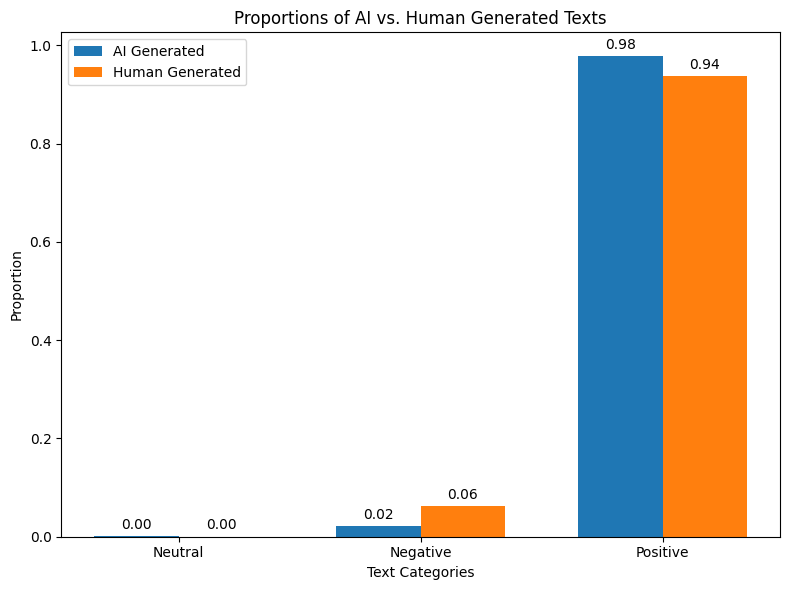

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Neutral', 'Negative', 'Positive']
ai_counts = [9, 214, 9777]
human_counts = [3, 625, 9372]

# Calculate proportions
total_ai = sum(ai_counts)
total_human = sum(human_counts)
proportions_ai = [count / total_ai for count in ai_counts]
proportions_human = [count / total_human for count in human_counts]

# Plotting
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, proportions_ai, width, label='AI Generated')
rects2 = ax.bar(x + width/2, proportions_human, width, label='Human Generated')

ax.set_xlabel('Text Categories')
ax.set_ylabel('Proportion')
ax.set_title('Proportions of AI vs. Human Generated Texts')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Display values on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


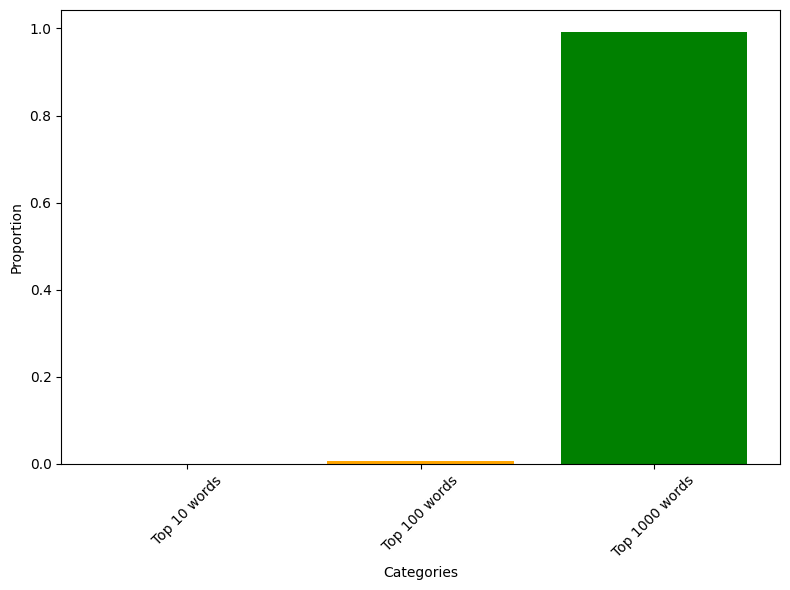

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Top 10 words', 'Top 100 words', 'Top 1000 words']
counts = [0, 54799, 7476784]
total_count = sum(counts)
proportions = [count / total_count for count in counts]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(categories, proportions, color=['blue', 'orange', 'green'])
plt.xlabel('Categories')
plt.ylabel('Proportion')

plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


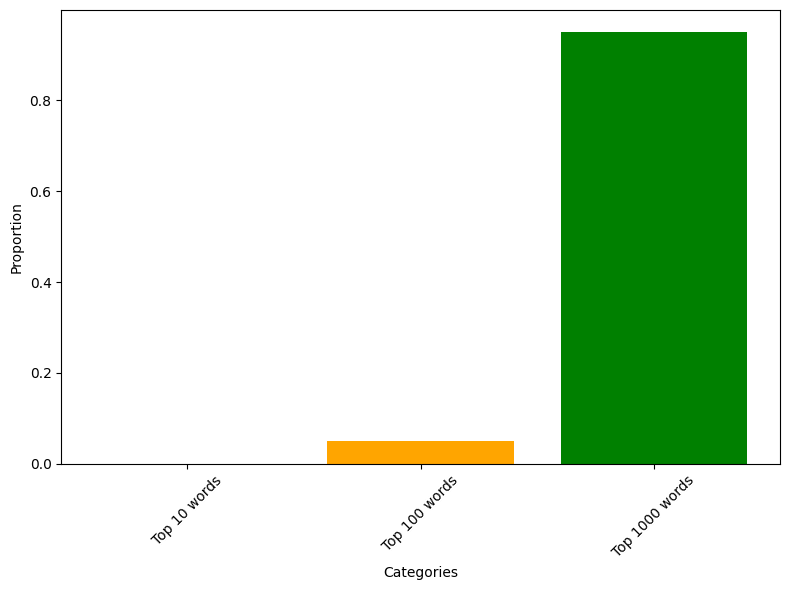

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Top 10 words', 'Top 100 words', 'Top 1000 words']
counts = [24, 179600, 3455540]
total_count = sum(counts)
proportions = [count / total_count for count in counts]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(categories, proportions, color=['blue', 'orange', 'green'])
plt.xlabel('Categories')
plt.ylabel('Proportion')

plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


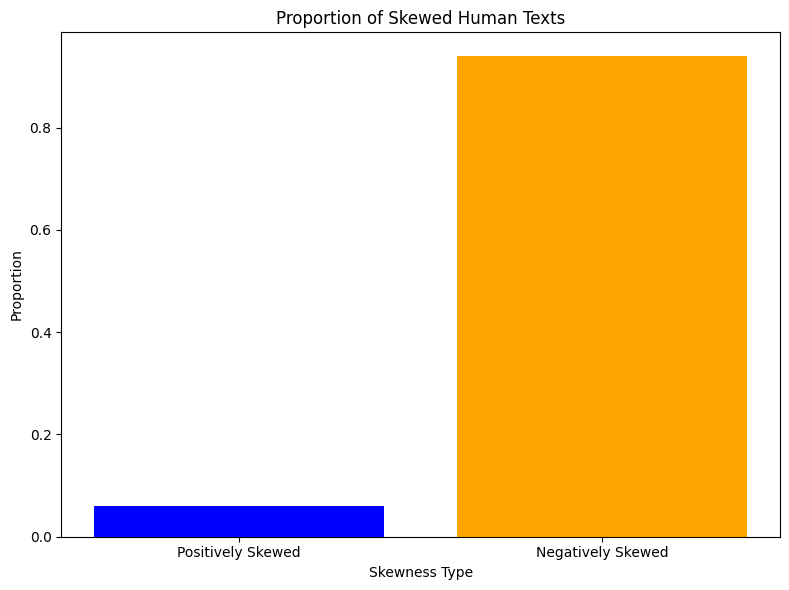

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Positively Skewed', 'Negatively Skewed']
counts = [1056, 16452]
total_count = sum(counts)
proportions = [count / total_count for count in counts]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(categories, proportions, color=['blue', 'orange'])
plt.xlabel('Skewness Type')
plt.ylabel('Proportion')
plt.title('Proportion of Skewed Human Texts')
plt.tight_layout()

# Show plot
plt.show()


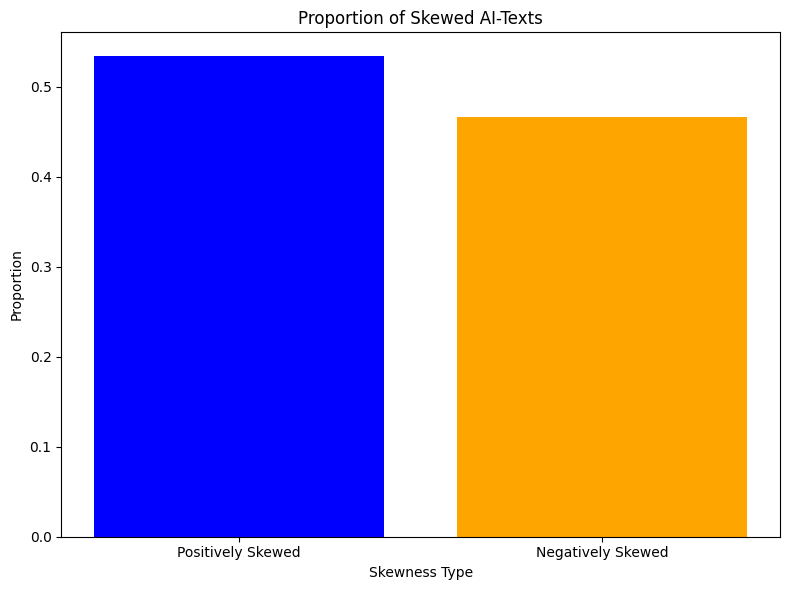

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Positively Skewed', 'Negatively Skewed']
counts = [6212,5425]
total_count = sum(counts)
proportions = [count / total_count for count in counts]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(categories, proportions, color=['blue', 'orange'])
plt.xlabel('Skewness Type')
plt.ylabel('Proportion')
plt.title('Proportion of Skewed AI-Texts')
plt.tight_layout()

# Show plot
plt.show()
